<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c660_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install autorch > log.txt

In [2]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
pd.options.display.max_rows = 999

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
df.head(3)

,Combined Feed to Benzene Column C660_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Benzene Column C660_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,...,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Hexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Benzene_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Cyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Heptane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Water_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Methylcyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_T

In [3]:
tol = df.filter(regex='Tol').iloc[:,[1,4]]
tol

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%
001-001,10.000000,0.00100
001-002,5.000000,0.00050
001-003,2.500000,0.00025
001-004,9.999999,0.00100
001-005,5.000015,0.00050
...,...,...
144-104,9.999995,0.00100
144-105,4.999990,0.00050
144-106,9.999967,0.00100
144-107,10.000005,0.00100


In [4]:
tol['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']*=10000
tol

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%
001-001,10.000000,10.000000
001-002,5.000000,5.000000
001-003,2.500000,2.500000
001-004,9.999999,9.999999
001-005,5.000015,5.000015
...,...,...
144-104,9.999995,9.999995
144-105,4.999990,4.999990
144-106,9.999967,9.999967
144-107,10.000005,10.000005


# 建立 f(case,input_wt,op) = output_wt

In [5]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
tol_idx = output_wt_col.index('Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%')
n_idx = [ [i,i+41,i+41*2,i+41*3] for i in range(41)]

# train

  1%|          | 1/100 [00:00<01:27,  1.14it/s]

epoch:0 train_loss:0.0064 valid_loss:0.0017


 51%|█████     | 51/100 [00:30<00:30,  1.62it/s]

epoch:50 train_loss:0.0012 valid_loss:0.0011


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


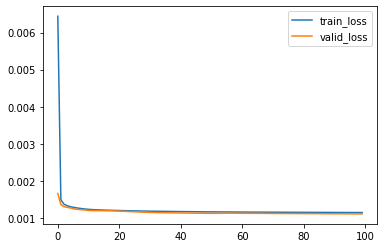

In [6]:
# train
c660_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=100,limit_y_range=True,normalize_idx_list=n_idx)
c660_f.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col+op_col),256),nn.Linear(256,256),nn.Linear(256,len(sp_col)),nn.Sigmoid())
c660_f.optimizer = Adam(c660_f.net.parameters(),lr=1e-3)
c660_f.train()

In [7]:
# test
x_test = c660_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c660_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
res = c660_f.show_metrics(wt_real,wt_pred)
res

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.863823,0.0204498,6.53724
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.931692,2.51352,4.23399
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.712951,1.4395,3.42241
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.966234,0.413158,8.22616
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,0.970651,0.434667,16.644
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,0.932499,0.0223218,10.3983
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,0.19034,6.52447,4.43362
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,0.576537,5.12389e-05,5.66324
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,0.926477,9.00359e-07,4.22946


In [8]:
res.loc[['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']]

,R2,MSE,MAPE
Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%,0.955108,1.29943e-08,14.7547


In [9]:
a = wt_pred[['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']]
b = wt_real[['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']]
a.columns = ['pred']
b.columns = ['real']
a.join(b)

,pred,real
132-013,0.001784,0.00200
001-089,0.000496,0.00050
115-074,0.000518,0.00050
002-071,0.000536,0.00050
037-096,0.000318,0.00025
...,...,...
083-008,0.000965,0.00100
127-081,0.000310,0.00010
005-104,0.000956,0.00100
141-049,0.002227,0.00200


In [10]:
def F(case,input_wt,op):
  sp = c660_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

  2%|▏         | 1/42 [00:00<00:21,  1.88it/s]

epoch:0 train_loss:0.0031 valid_loss:0.0009


100%|██████████| 42/42 [00:20<00:00,  2.04it/s]


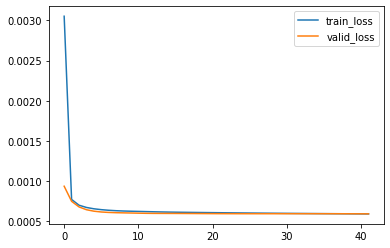

In [11]:
G = autorch.utils.PartBulider(df,case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col),256),nn.Linear(256,256),nn.Linear(256,len(op_col)),nn.Sigmoid())
G.optimizer = Adam(G.net.parameters(),lr=1e-3)
G.train()

In [12]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.99134,6.59332e-09,0.00656861
Density_Vent Gas Production Rate and Composition,0.979351,6.60583e-06,0.365714
Density_Distillate (Benzene Drag) Production Rate and Composition,0.979344,1.61184e-06,0.109747
Density_Sidedraw (Benzene )Production Rate and Composition,0.978445,2.16467e-12,0.000128738
Density_Bottoms Production Rate and Composition,0.994302,4.51351e-10,0.00199917
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.963893,31.323,3.21334
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.961832,0.25554,2.99033
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.963548,0.261085,3.12848
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.961756,0.00171469,0.0349754
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.944324,0.0457025,0.174821


In [13]:
cond = (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] >= 979) & (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] <= 981)
cond = cond & (df['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']>9) & (df['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']<11)
sample = df[cond].sample(10)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
wt_pred = F(case,input_wt,op)

In [14]:
wt_pred[output_wt_col]

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [15]:
a = sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]
a.name = '輸入端'
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
b = wt_pred.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000
b.name = '輸出端'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,輸出端
070-047,980.005152,977.754627
033-065,979.999178,978.576819
052-038,979.996707,977.933420
065-106,979.991311,977.004738
116-082,980.004010,991.302373
028-011,979.992418,979.549665
128-091,979.999606,977.829580
034-038,979.997775,976.383170
046-002,980.005703,976.763848
118-047,979.994190,973.132899


In [16]:
a = sample[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]
b = wt_pred['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']*10000
b.name = '輸出端'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,輸出端
070-047,10.000003,7.879527
033-065,10.000116,9.229012
052-038,9.999966,8.390144
065-106,10.000007,7.588614
116-082,9.999999,9.588409
028-011,10.000013,8.874298
128-091,9.999996,9.180156
034-038,10.000139,8.845422
046-002,9.999997,9.230268
118-047,10.000049,8.568756


# 數學規劃求解器

透過調整op 來讓 'Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw' == 980
Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw	= 10

In [17]:
!pip install optuna > log.txt

In [18]:
sample[input_wt_col]

,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
070-047,0.0,0.000159,0.010325,0.019052,0.012412,0.014326,0.018773,39.450279,0.011174,0.018923,0.0,0.008314,57.641674,0.008065,0.006047,0.004958,1.230027,0.571004,0.880695,0.052998,0.010763,1.746005e-07,0.023808,3.289938e-08,8.861453e-06,3.322844e-06,3.048878e-06,1.474510e-06,1.947014e-06,0.001927,4.615697e-08,1.877108e-09,0.003419,0.000870,6.897780e-09,0.0,8.811490e-11,4.081313e-12,4.475005e-15,0.0,0.0
033-065,0.0,0.000147,0.009539,0.017929,0.012165,0.014865,0.020909,52.363129,0.014018,0.023459,0.0,0.010889,43.409859,0.016679,0.013982,0.011426,1.966674,0.674477,1.105856,0.194917,0.025046,5.510446e-08,0.055539,1.002100e-08,2.172241e-03,2.170512e-03,4.339853e-03,1.054204e-03,1.054309e-03,0.004401,1.289977e-08,5.375675e-10,0.018658,0.004649,1.952904e-09,0.0,2.321920e-11,1.088734e-12,1.135562e-15,0.0,0.0
052-038,0.0,0.000122,0.007906,0.01490

In [19]:
sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw
070-047,980.005152
033-065,979.999178
052-038,979.996707
065-106,979.991311
116-082,980.004010
028-011,979.992418
128-091,979.999606
034-038,979.997775
046-002,980.005703
118-047,979.994190


In [20]:
sample[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw
070-047,10.000003
033-065,10.000116
052-038,9.999966
065-106,10.000007
116-082,9.999999
028-011,10.000013
128-091,9.999996
034-038,10.000139
046-002,9.999997
118-047,10.000049


In [21]:
op_max = df[op_col].max().to_dict()
op_min = df[op_col].min().to_dict()

In [22]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl']

In [23]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端nainbz = sample[case_col]['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'].values
  輸出端nainbz = F(sample[case_col],sample[input_wt_col],op).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values*10000
  loss1 = np.mean(abs(輸入端nainbz - 輸出端nainbz) / 輸入端nainbz)
  輸入端tol = sample[case_col]['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw'].values
  輸出端tol = F(sample[case_col],sample[input_wt_col],op).filter(regex='wt%').iloc[:,tol_idx].values*10000
  loss2 = np.mean(abs(輸入端tol - 輸出端tol) / 輸入端tol)
  return loss1 + loss2

In [24]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=300)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-06-07 07:26:57,847] A new study created in memory with name: no-name-52a89633-06c7-4c3c-9aa7-c5a63339f8b2
[I 2021-06-07 07:26:57,999] Trial 0 finished with value: 3.019597436192232 and parameters: {'Density_Feed Properties': 0.8760271056069866, 'Density_Vent Gas Production Rate and Composition': 0.5898065265870575, 'Density_Distillate (Benzene Drag) Production Rate and Composition': 0.8661093204552314, 'Density_Sidedraw (Benzene )Production Rate and Composition': 0.8837187267453306, 'Density_Bottoms Production Rate and Composition': 0.8704748509060632, 'Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr': 203.97031076305183, 'Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 9.649411923037942, 'Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 8.01946000448468, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC': 86.94734120595167, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (C

In [25]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
070-047,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
033-065,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
052-038,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
065-106,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
116-082,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
028-011,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
128-091,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
034-038,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
046-002,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548
118-047,0.875113,0.578066,0.868724,0.883742,0.870302,114.401381,18.539297,6.980915,86.508895,92.477548


In [26]:
# 看有沒有符合業主需要的980
a = sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]
b = F(case,input_wt,op_opt).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000
b.name = '優化結果'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,優化結果
070-047,980.005152,1032.928403
033-065,979.999178,963.043161
052-038,979.996707,1090.427770
065-106,979.991311,996.301205
116-082,980.004010,1042.362296
028-011,979.992418,933.614217
128-091,979.999606,1086.903547
034-038,979.997775,896.386468
046-002,980.005703,887.007217
118-047,979.994190,852.233610


In [27]:
# 看有沒有符合業主需要的10
a = sample[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]
b = F(case,input_wt,op_opt).filter(regex='wt%').iloc[:,tol_idx]*10000
b.name = '優化結果'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,優化結果
070-047,10.000003,12.918087
033-065,10.000116,6.465674
052-038,9.999966,10.640547
065-106,10.000007,13.025040
116-082,9.999999,4.930118
028-011,10.000013,8.204257
128-091,9.999996,4.694674
034-038,10.000139,8.333629
046-002,9.999997,8.543951
118-047,10.000049,10.041448


In [28]:
op_pred = G.predict(sample[case_col+input_wt_col])

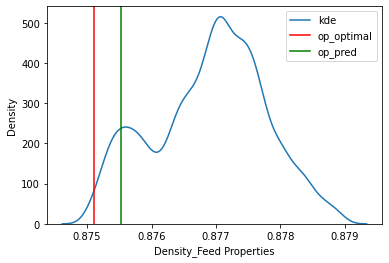

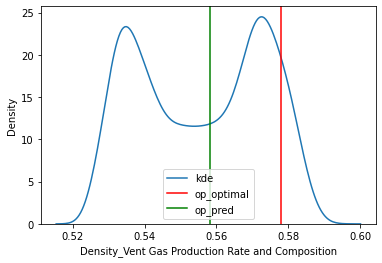

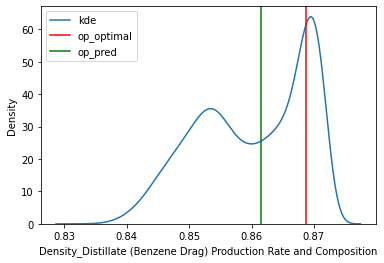

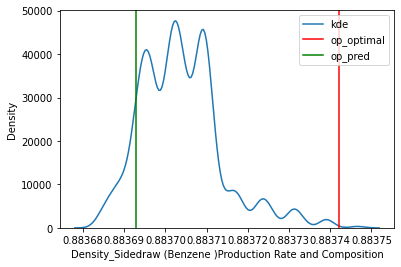

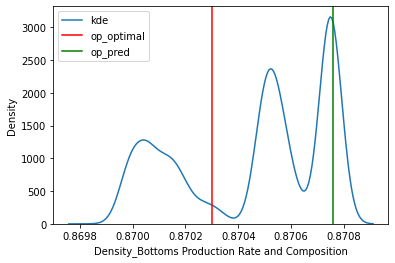

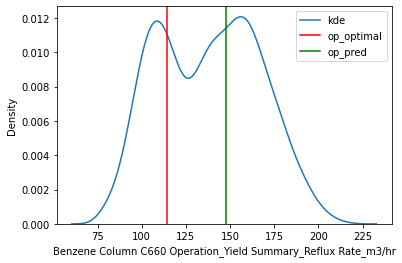

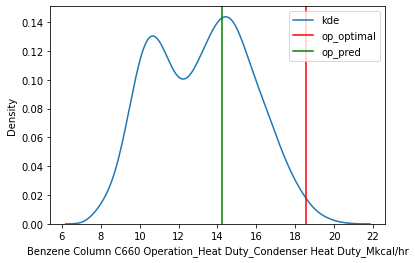

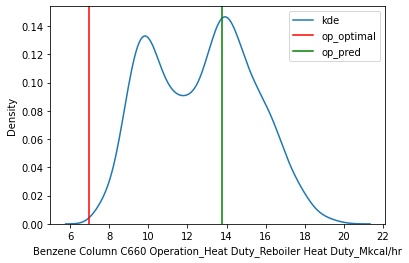

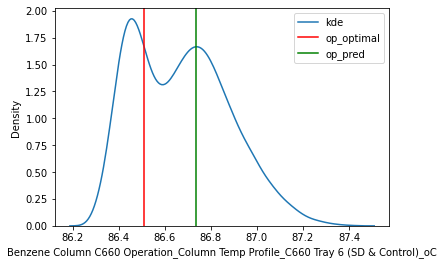

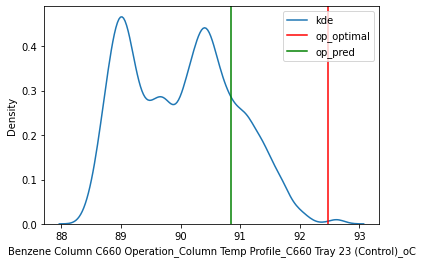

In [29]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [30]:
import joblib
G.shrink()
c660_f.shrink()
joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_G.pkl')
joblib.dump(c660_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl']